In [37]:
!pip install compress_fasttext

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 24.2 MB 8.9 MB/s            
  Created wheel for compress-fasttext: filename=compress_fasttext-0.0.7-py3-none-any.whl size=11078 sha256=ab28be9bbe1182d81b8684d12f89445e9f743795bb88660eb51c4be0ac0dca3f
  Stored in directory: /Users/yassinefakhreddine/Library/Caches/pip/wheels/fa/cf/43/579ed0c5dc7f41928de0cbd42d06c0ffbd8731d48ba0ac2587
Successfully built compress-fasttext
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [38]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier

import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna import Trial
from tqdm.notebook import tqdm

from gensim.models.fasttext import load_facebook_model
import compress_fasttext
import fasttext
import fasttext.util

In [41]:
stops = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
         'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
         'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
         'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
         'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
         'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
         'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
         'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
         'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
         'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should',
         "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
         'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
         'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
         'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

In [42]:
data =  pd.read_csv("../../DBS Data Scientist Mini Project/data/features.csv")
labels = pd.read_csv("../../DBS Data Scientist Mini Project/data//labels.csv")

# Reorder labels to match data order
data = pd.merge(data,labels)
labels = data["genre"]
data.drop(columns=["genre"], inplace=True)

n_classes = labels.unique().shape[0]

In [43]:
unused_features = ["trackID"]
tag_feature = ["tags"]
title_feature = ["title"]
categorical_features = ["key", "mode"]
numerical_features = data.columns[~data.columns.isin(categorical_features + tag_feature + 
                                                     unused_features+title_feature)]

# Preprocessing

TODO: <br>
 - Drop Unused Columns 
 - Impute/Drop Missing Values
 - Tags Embeding 
     - FastText good result but model too large, using compress technique big loss on the model performance
     - Doc2Vec not good 
     - Bag of words & Tf-Idf not good enough 
 - Scale Numerical Value
 - PCA 
     - After Few tries it reduces the performance of the model 
 - One Hot Encoding 

In [ ]:
ft_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load("mini_cc.en.300.bin")

In [44]:
data["tags"] = data["tags"].str.replace(",", "")

In [45]:
def remove_stops(X):
    return [" ".join([word for word in s.split() if word not in stops]) for s in X]

In [46]:
text_pipeline = Pipeline([ 
    ("imputer", SimpleImputer(strategy="constant", fill_value="",)),
    ("reshape", FunctionTransformer(np.reshape, kw_args={"newshape":-1})),
    ("tfids", TfidfVectorizer())
    #("fasttext", FunctionTransformer(lambda x: pd.DataFrame([g_ft.wv.get_vector(s) for s in tqdm(x)])))
])

In [47]:
numerical_pipeline = Pipeline([ 
    ("imputer", SimpleImputer(strategy="mean")),
    ("std_scaler", StandardScaler())
])

In [48]:
categorical_pipeline = Pipeline([ 
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder())
])

In [49]:
preprocessing_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_features),
    ("categorical", categorical_pipeline, categorical_features),
    ("tags", text_pipeline, tag_feature),
    ("titles", text_pipeline, title_feature)
])

# Training

In [50]:
def compute_metrics(y_true, y_pred):
    print(f"acc: {accuracy_score(y_true, y_pred)}")
    print(f"kappa: {cohen_kappa_score(y_pred, y_true)}")
          
    ConfusionMatrixDisplay.from_predictions(y_pred, y_val, 
                          display_labels=label_encoder.classes_, xticks_rotation="vertical")

In [51]:
def study_report(study):
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    stratify=labels.values.reshape(-1,1),
                                                    test_size=0.15, shuffle=True, random_state=42)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train,
                                                    test_size=0.15, shuffle=True, random_state=42)

In [24]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_val = preprocessing_pipeline.transform(X_val)
X_test = preprocessing_pipeline.transform(X_test)

In [25]:
X_train.shape, y_train.shape

((5871, 10300), (5871,))

### XGB

In [15]:
def objective(trial, dtrain, evals, params):
    
    params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
    params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    params["subsample"] = trial.suggest_float("subsample", 0.2, 1.0)
    params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    params["lambda"] = trial.suggest_float("lambda", 1e-8, 1.0, log=True)
    params["alpha"] = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=evals,
        num_boost_round=2500,
        early_stopping_rounds=20,
        verbose_eval=100
    )    
    # xgb_model.best_score --> log loss
    y_pred = xgb_model.predict(dval).argmax(axis=1)
    return cohen_kappa_score(y_pred, y_v)

In [16]:
params = {
    "verbosity": 0,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": n_classes
}

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

deval = [(dval, 'eval')] 

In [ ]:
xgb_study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, dtrain, deval, params), n_trials=20, timeout=600)

In [ ]:
study_report(xgb_study)

In [ ]:
xgb_model = xgb.train(
    params={**params,**trial.params},
    dtrain=dtrain,
    evals=deval,
    num_boost_round=2500,
    early_stopping_rounds=50,
    verbose_eval=50
) 

In [ ]:
y_pred = xgb_model.predict(dval).argmax(axis=1)
compute_metrics(y_pred, y_val)

### LGB

In [52]:
def lgb_objective(trial, dtrain, dval, params):    
    param = {**params,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    lgb_model = lgb.train(param, dtrain, valid_sets=[dval], num_boost_round=1000,
                    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(25)]
               )

    return lgb_model.best_score["valid_0"]["multi_logloss"]

In [56]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    #"device" : "gpu",
    "num_class": n_classes
}

In [57]:
dtrain = lgb.Dataset(X_train,y_train)
dval = lgb.Dataset(X_val, y_val)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: lgb_objective(trial, dtrain, dval, params), n_trials=20, timeout=600)

[I 2021-10-29 08:22:31,460] A new study created in memory with name: no-name-62f7de4d-abef-4c10-9668-7680c3e33e10


Training until validation scores don't improve for 25 rounds
[50]	valid_0's multi_logloss: 0.917397


In [77]:
study_report(study)

Number of finished trials:  100
Best trial:
  Value: 0.8591642720058137
  Params: 
    lambda_l1: 0.09686860149587874
    lambda_l2: 2.317278758305513
    num_leaves: 97
    feature_fraction: 0.7408758758129015
    bagging_fraction: 0.6861197195062518
    bagging_freq: 7
    min_child_samples: 78


```json
{
 'lambda_l1': 0.09686860149587874,
 'lambda_l2': 2.317278758305513,
 'num_leaves': 97,
 'feature_fraction': 0.7408758758129015,
 'bagging_fraction': 0.6861197195062518,
 'bagging_freq': 7,
 'min_child_samples': 78
 }
```

In [80]:
lgb_model = lgb.train({**params, **study.best_params}, dtrain, valid_sets=[dval], num_boost_round=1000,
                      callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.913926
[100]	valid_0's multi_logloss: 0.86879
[150]	valid_0's multi_logloss: 0.869252
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.864397


In [81]:
y_pred = lgb_model.predict(X_val).argmax(axis=1)

acc: 0.6972034715525555
kappa: 0.6397461102807191


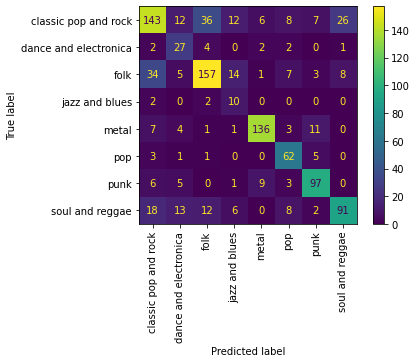

In [82]:
compute_metrics(y_val, y_pred)

# Full Pipeline Training

```json
{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'device': 'gpu',
 'num_class': 8,
 'lambda_l1': 0.09686860149587874,
 'lambda_l2': 2.317278758305513,
 'num_leaves': 97,
 'feature_fraction': 0.7408758758129015,
 'bagging_fraction': 0.6861197195062518,
 'bagging_freq': 7,
 'min_child_samples': 78}
```

In [26]:
X = preprocessing_pipeline.fit_transform(data)
y = label_encoder.transform(labels) 

In [91]:
d_Train = lgb.Dataset(X,y)

In [92]:
best_params = {'objective': 'multiclass',
 'metric': 'multi_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'num_class': 8,
 'lambda_l1': 0.09686860149587874,
 'lambda_l2': 2.317278758305513,
 'num_leaves': 97,
 'feature_fraction': 0.7408758758129015,
 'bagging_fraction': 0.6861197195062518,
 'bagging_freq': 7,
 'min_child_samples': 78}

In [93]:
final_model = lgb.train(best_params, d_Train, num_boost_round=lgb_model.best_iteration)

# Export Preprocess-Pipeline Model & Label Encoder

In [28]:
import joblib

In [98]:
joblib.dump(label_encoder, "label_encoder.bin")

['label_encoder.bin']

In [29]:
joblib.dump(preprocessing_pipeline, "preprocessing_pipeline.bin")

['preprocessing_pipeline.bin']

In [100]:
joblib.dump(lgb_model, "lgb_model.bin")

['lgb_model.bin']

In [101]:
joblib.dump(final_model, "final_model.bin")

['final_model.bin']